**Importing libraries**

In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# from pycaret.classification import *
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from os import listdir
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
filenames=list()
labels=list()

path='../input/dynamicrgb/New folder/'
for filename in listdir(path):
   filenames.append(filename)
   for i in reversed (range(1,28)):
        str1='a'+str(i)
        if(str1 in filename):
            labels.append(i)
            break
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
def _parse_function(filename, label):
    image_string = tf.io.read_file(path+filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)

In [28]:
def preprocess_test(image, label):
  image = tf.image.resize(image,[256,256])
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image
train_A = dataset.cache().map(
    preprocess_test, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [29]:
print(len(train_A))
print(len(labels))
from collections import Counter
items = Counter(labels).keys()
print(items)

861
861
dict_keys([8, 7, 13, 24, 6, 3, 18, 22, 4, 17, 9, 10, 16, 19, 23, 11, 15, 25, 1, 20, 27, 12, 14, 21, 26, 2, 5])


In [30]:
X=[]
for i in train_A:
   X.append(i[0])

In [31]:
Y=labels
print(len(X))
print(len(Y))
# X

861
861


In [32]:
X[0].shape

TensorShape([256, 256, 3])

In [33]:
import sys,os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
np.save('X_test',X_test)
np.save('y_test',y_test)

In [34]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

688
688
173
173


In [35]:
lab=[]
for i in range (1,28):
  lab.append(i)

In [ ]:

y_train = pd.get_dummies(y_train).to_numpy()
print(y_train.shape)

**Main Extractor Model**

In [40]:
import tensorflow as tf
from tensorflow import keras
IMG_SHAPE = (256,256, 3)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

base_model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(27, activation='sigmoid')
])

base_model.summary()

base_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 27)                27675     
Total params: 3,256,539
Trainable params: 27,675
Non-trainable params: 3,228,864
_________________________________________________________________


In [41]:
base_model.fit(np.array(X_train), np.array(y_train),batch_size=1,epochs=240,verbose=1,shuffle=True)

Epoch 1/240
688/688 [==============================] - 6s 7ms/step - loss: 0.2026 - accuracy: 0.0567
Epoch 2/240
688/688 [==============================] - 4s 5ms/step - loss: 0.1950 - accuracy: 0.1206
Epoch 3/240
688/688 [==============================] - 4s 5ms/step - loss: 0.1896 - accuracy: 0.1701
Epoch 4/240
688/688 [==============================] - 4s 6ms/step - loss: 0.1765 - accuracy: 0.2384
Epoch 5/240
688/688 [==============================] - 3s 5ms/step - loss: 0.1710 - accuracy: 0.3009
Epoch 6/240
688/688 [==============================] - 3s 5ms/step - loss: 0.1598 - accuracy: 0.3488
Epoch 7/240
688/688 [==============================] - 4s 5ms/step - loss: 0.1565 - accuracy: 0.3576
Epoch 8/240
688/688 [==============================] - 3s 5ms/step - loss: 0.1495 - accuracy: 0.4419
Epoch 9/240
688/688 [==============================] - 4s 5ms/step - loss: 0.1472 - accuracy: 0.4360
Epoch 10/240
688/688 [==============================] - 4s 6ms/step - loss: 0.1387 - accura

In [42]:
# y_test = pd.get_dummies(y_test).to_numpy()
y_tes = pd.get_dummies(y_test).to_numpy()
base_model.evaluate(np.array(X_test), np.array(y_tes),verbose=0)[1]

0.6994219422340393

In [43]:
Extractor1=tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False)
# Extractor1.summary()
Extractor1 = tf.keras.Sequential([
  Extractor1,
  keras.layers.GlobalAveragePooling2D(),
])
y_pred1=Extractor1.predict(np.array(X_train))
y_pred1.shape

y_pred2=Extractor1.predict(np.array(X_test))
y_pred2.shape

(173, 1024)

**Extracting Skeltal Data to fuse it with dynamic rgb**

In [44]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# from pycaret.classification import *
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [45]:
# for filename in listdir(path):
#     print(filename)
new_set = [x.replace('color.jpg', 'skeleton.mat') for x in listdir(path)]
# new_set

In [46]:
train=[]
test=[]
dataDir = "../input/skelton/Skeleton/"

for i in range (0,688):
    train.append([loadmat(dataDir+new_set[i])["d_skel"],new_set[i].split("_")[0]])



In [47]:
for i in range (688,861):
    test.append([loadmat(dataDir+new_set[i])["d_skel"],new_set[i].split("_")[0]])

In [48]:
print(len(train))
print(len(test))

688
173


In [49]:
from numpy import array

#trimming the frames
def trim(x,minvalue):
    r = (x.shape[2]/(minvalue) )
    array = []
    t=0+r
    i=int(t)
    # print(x.shape[2])
    while i+1 < x.shape[2]:
        array.append( x[:,:,i] + ( (x[:,:,i] - x[:,:,i+1])*(t-i) )  )
        t+=r
        i=int(t)-1
    return np.array(array)[:40].transpose(1,2,0)
print(test[-1][0].shape)
print(trim(test[-1][0],41).shape)

(20, 3, 49)
(20, 3, 40)


**Euclidean distance from shoulder center to joint points**

In [50]:
d = lambda x1,y1,z1,x2,y2,z2 : ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5
def dist_func(skl):
    dvals = d(skl[:,0,:],skl[:,1,:],skl[:,2,:],skl[1,0,:],skl[1,1,:],skl[1,2,:])
    dvals = (dvals[:]-dvals.mean())/dvals.std()
    return dvals

**Finding the euclidean distance using manual method
Storing the x, y and z of all the joint points of first frame**

In [51]:
x = train[0][0][:,0,0]
y = train[0][0][:,1,0]
z = train[0][0][:,2,0]

**Euclidean distance from shoulder center to all other joint points**

In [52]:
d(x,y,z,x[1],y[1],z[1])

array([0.18483592, 0.        , 0.32442852, 0.3875136 , 0.18820802,
       0.40708027, 0.59829264, 0.63953164, 0.18785745, 0.40893128,
       0.60126103, 0.63276378, 0.46297625, 0.81001178, 1.22287026,
       1.28500556, 0.46326141, 0.88866929, 1.23583816, 1.28534957])

**Finding the euclidean distance using dist_func (numpy slicing and lambda mapping)
Storing the x, y and z of all the joint points of first frame**

In [53]:
np.array([dist_func(train[0][0])[i][0] for i in range(20)])

array([-1.06727118, -1.53854419, -0.7113543 , -0.55050732, -1.05867338,
       -0.50061851, -0.01308758,  0.09205881, -1.05956722, -0.49589904,
       -0.00551913,  0.07480291, -0.35810147,  0.52672912,  1.5793874 ,
        1.73781271, -0.35737441,  0.72728084,  1.61245143,  1.73868983])

**Finding the distance for the values stored in train and test dataset**

In [54]:
def return_distance_and_action(mats):
    x = []
    y = []
    for skl in mats:
        x.append(dist_func(trim(skl[0],41)).flatten())
        y.append(skl[1])
    return np.array(x),np.array(y)

In [55]:
X_train1,y_train1 = return_distance_and_action(train)
X_test1,y_test1 = return_distance_and_action(test)

In [56]:
print(X_train1.shape)
print(y_train1.shape)
print(len(X_train))
# y_train

(688, 800)
(688,)
688


In [57]:

dtc = DecisionTreeClassifier()
dtc.fit(X_train1, y_train1)
y_pred = dtc.predict(X_test1)
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.5953757225433526


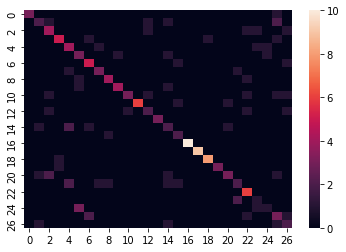

In [58]:
sns.heatmap(confusion_matrix(y_test1,y_pred))
plt.show()

In [59]:
import lightgbm as lgb
dtc = lgb.LGBMClassifier()
dtc.fit(X_train1, y_train1)
y_pred = dtc.predict(X_test1)
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.8208092485549133


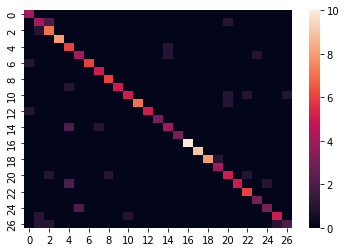

In [60]:
sns.heatmap(confusion_matrix(y_test1,y_pred))
plt.show()

# **FUSION OF BOTH DATA MATRICES** 

In [61]:
print(y_pred1.shape)
print(y_pred2.shape)

(688, 1024)
(173, 1024)


In [62]:
import numpy as np
A = (X_train1 - np.mean(X_train1)) / np.std(X_train1)
B = (y_pred1 - np.mean(y_pred1)) / np.std(y_pred1)
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=2)
cca.fit(A,B)
X_c, Y_c = cca.transform(A,B)
print(X_c.shape)

(688, 2)


In [63]:
print(X_c.shape)
print(Y_c.shape)

(688, 2)
(688, 2)


In [64]:
import numpy as np
k=np.cov(X_c, Y_c)
k.shape 

(1376, 1376)

In [65]:
fusion_matrix = np.stack((X_c,Y_c), axis = 1)
fusion_matrix.shape

(688, 2, 2)

Now using ytrain and fusion matrix to train data to obtain better results

In [66]:
y_=y_train
len(y_)

688

In [67]:
A1 = (X_test1 - np.mean(X_test1)) / np.std(X_test1)
B1 = (y_pred2 - np.mean(y_pred2)) / np.std(y_pred2)

cca.fit(A1,B1)
X_c1, Y_c1 = cca.transform(A1,B1)
X_testF = np.stack((X_c1, Y_c1), axis = 1)
X_testF.shape
X_testF=X_testF.reshape((173,4))
                        

In [68]:
k1=np.cov(X_c1, Y_c1)
k1.shape

(346, 346)

In [ ]:
X_=fusion_matrix.reshape((688,4))
print(X_.shape)
print(y_.shape)

yt1=pd.get_dummies(y_test1).to_numpy()
print(X_testF.shape)
print(yt1.shape)

dtc = ExtraTreesClassifier()
dtc.fit(X_testF, y_test1)
y_pred = dtc.predict(X_)
# print("Accuracy: ",accuracy_score(y_train1,y_pred))
# print("Accuracy: ",accuracy_score(y_train1,y_pred))

In [70]:
# X_tr1 = np.stack((X_train1, y_pred1), axis = 1)
# X_te1 = np.stack((X_test1, y_pred2), axis = 1)
print(X_train1.shape)
# print(X_te1.shape)

xtr1=[]

for i in range (0,688):
    xtr1.append(list(X_train1[i]))
    for j in range (0,1024):
        xtr1[i].append(y_pred1[i][j])
        
xtr1=np.array(xtr1) 
print(xtr1.shape)


xtr2=[]

for i in range (0,173):
    xtr2.append(list(X_test1[i]))
    for j in range (0,1024):
        xtr2[i].append(y_pred2[i][j])
        
xtr2=np.array(xtr2) 
print(xtr2.shape)



(688, 800)
(688, 1824)
(173, 1824)


In [71]:
dtc = DecisionTreeClassifier()
dtc.fit(xtr1, y_train1)
y_pred = dtc.predict(xtr2)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.5375722543352601
Accuracy:  0.5375722543352601


In [72]:
import lightgbm as lgb
dtc = lgb.LGBMClassifier()
dtc.fit(xtr1, y_train1)
y_pred = dtc.predict(xtr2)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.8554913294797688
Accuracy:  0.8554913294797688


In [73]:
dtc = XGBClassifier()
dtc.fit(xtr1, y_train1)
y_pred = dtc.predict(xtr2)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

[08:10:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7803468208092486
Accuracy:  0.7803468208092486


# **PCA**

In [74]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=688)
A1 = (xtr1 - np.mean(xtr1)) / np.std(xtr1)
B1 = (xtr2 - np.mean(xtr2)) / np.std(xtr2)

pca2.fit(A1)
xtr3= pca2.transform(A1)
xtr4= pca2.transform(B1)

In [75]:
dtc = XGBClassifier()
dtc.fit(xtr3, y_train1)
y_pred = dtc.predict(xtr4)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

[08:11:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.653179190751445
Accuracy:  0.653179190751445


In [76]:
dtc = ExtraTreesClassifier()
dtc.fit(xtr3, y_train1)
y_pred = dtc.predict(xtr4)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.6647398843930635
Accuracy:  0.6647398843930635


In [77]:
dtc = lgb.LGBMClassifier()
dtc.fit(xtr3, y_train1)
y_pred = dtc.predict(xtr4)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.7341040462427746
Accuracy:  0.7341040462427746


# **LDA**

In [78]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=25)
X_r2 = lda.fit(A1, y_train1).transform(A1)
X_r3 = lda.fit(A1, y_train1).transform(B1)

In [79]:
print(X_r2.shape)
print(X_r3.shape)


(688, 25)
(173, 25)


In [80]:
dtc = ExtraTreesClassifier()
dtc.fit(X_r2, y_train1)
y_pred = dtc.predict(X_r3)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.9075144508670521
Accuracy:  0.9075144508670521


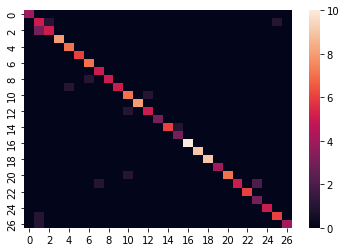

In [81]:
sns.heatmap(confusion_matrix(y_test1,y_pred))
plt.show()

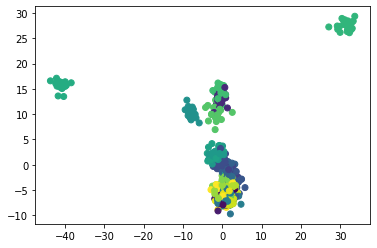

In [82]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_r21 = lda.fit(A1, y_train1).transform(A1)
X_r31 = lda.fit(A1, y_train1).transform(B1)


y12=label_encoder.fit_transform(y_train1)
plt.figure()
plt.scatter(X_r21[:,0],X_r21[:,1],c=y12)
plt.show()

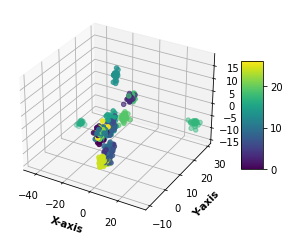

In [83]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
X_r21 = lda.fit(A1, y_train1).transform(A1)
X_r31 = lda.fit(A1, y_train1).transform(B1)


y12=label_encoder.fit_transform(y_train1)
fig=plt.figure()
ax = plt.axes(projection ="3d")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')

sctt=ax.scatter3D(X_r21[:,0],X_r21[:,1],X_r21[:,2],c=y12)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

In [84]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score

In [85]:

def get_stacking():
    level0 = list()
    level0.append(('tree1',ExtraTreesClassifier()))
    level0.append(('tree2',ExtraTreesClassifier()))
    level0.append(('tree3',ExtraTreesClassifier()))
    level0.append(('tree4',ExtraTreesClassifier()))
    level1 = ExtraTreesClassifier()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

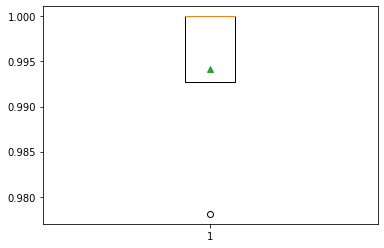

In [86]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy')
    return scores

model=get_stacking()
model.fit(X_r2, y_train1)
results=evaluate_model(model, X_r2, y_train1)
pyplot.boxplot(results, showmeans=True)
pyplot.show()

In [87]:
y_pred = model.predict(X_r3)
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.9017341040462428


# **DEEP NEURAL NETWORK**

In [88]:
# Use scikit-learn to grid search the number of neurons
import numpy
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Function to create model, required for KerasClassifier
def create_model(neurons=25):
    model = Sequential()
    model.add(Dense(200, input_dim=25, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(150, input_dim=200, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=100, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(27, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

seed = 7
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=3, verbose=0)

In [89]:
m1=create_model(25)
m1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 200)               5200      
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_25 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 27)               

In [90]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train12= label_encoder.fit_transform(y_train1)

In [91]:
model.fit(X_r2,y_train12)


In [92]:
y121=model.predict(X_r3)
y_test12= label_encoder.transform(y_test1)

In [93]:
print("Accuracy: ",accuracy_score(y_test12,y121))

Accuracy:  0.8554913294797688


# **VGG-16 Feature Extractor**

In [104]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

conv_base = tf.keras.Sequential([
  conv_base,
  keras.layers.GlobalAveragePooling2D(),
])

In [105]:
y_pr1=conv_base.predict(np.array(X_train))
print(y_pr1.shape)

y_pr2=conv_base.predict(np.array(X_test))
print(y_pr2.shape)

(688, 512)
(173, 512)


In [106]:

xr1=[]

for i in range (0,688):
    xr1.append(list(X_train1[i]))
    for j in range (0,512):
        xr1[i].append(y_pr1[i][j])
        
xr1=np.array(xtr1) 
print(xr1.shape)


xr2=[]

for i in range (0,173):
    xr2.append(list(X_test1[i]))
    for j in range (0,512):
        xr2[i].append(y_pr2[i][j])
        
xr2=np.array(xtr2) 
print(xr2.shape)


(688, 1824)
(173, 1824)


In [107]:
A121 = (xtr1 - np.mean(xr1)) / np.std(xr1)
B121 = (xtr2 - np.mean(xr2)) / np.std(xr2)


In [108]:
lda = LinearDiscriminantAnalysis(n_components=25)
X_r21 = lda.fit(A121, y_train1).transform(A121)
X_r31 = lda.fit(A121, y_train1).transform(B121)

In [113]:
model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=3, verbose=0)
model.fit(X_r21,y_train12)

In [109]:
dtc = ExtraTreesClassifier()
dtc.fit(X_r21, y_train1)
y_pred = dtc.predict(X_r31)
print("Accuracy: ",accuracy_score(y_test1,y_pred))
print("Accuracy: ",accuracy_score(y_test1,y_pred))

Accuracy:  0.9132947976878613
Accuracy:  0.9132947976878613


In [114]:
y121=model.predict(X_r31)
y_test12= label_encoder.transform(y_test1)

In [115]:
print("Accuracy: ",accuracy_score(y_test12,y121))

Accuracy:  0.8439306358381503
